In [2]:
import pandas as pd
import networkx as nx
import igraph as ig
import matplotlib.pyplot as plt
from tqdm import tqdm
import spacy


# Read CSV

In [3]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("./wiki_sentences_v2.csv")
# candidate_sentences.shape
candidate_sentences

,sentence
0,"confused and frustrated, connie decides to lea..."
1,"later, a woman’s scream is heard in the distance."
2,christian is then paralyzed by an elder.
3,the temple is set on fire.
4,"outside, the cult wails with him."
...,...
4313,"confidencial also responded negatively, callin..."
4314,and le parisien gave the film their highest fi...
4315,"the museum collection includes 37,000 film tit..."
4316,its predecessor was the dutch historical film ...


# Load NLP

In [4]:
nlp = spacy.load('en_core_web_sm')
doc = nlp("confused and frustrated, connie decides to leave on her own.")
for tok in doc:
    print(tok.text, "...", tok.dep_)

confused ... advcl
and ... cc
frustrated ... conj
, ... punct
connie ... nsubj
decides ... ROOT
to ... aux
leave ... xcomp
on ... prep
her ... poss
own ... pobj
. ... punct


# Entity Pairs Extraction

In [5]:
def get_entities(sent):
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""  # dependency tag of previous token in the sentence
    prv_tok_text = ""  # previous token in the sentence

    prefix = ""
    modifier = ""

    #############################################################

    for tok in nlp(sent):
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text

            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + tok.text

            if tok.dep_.find("subj") == True:
                ent1 = modifier + " " + prefix + " " + tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""

            if tok.dep_.find("obj") == True:
                ent2 = modifier + " " + prefix + " " + tok.text

            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
    #############################################################

    return [ent1.strip(), ent2.strip()]

In [6]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [7]:
entity_pairs = []
for i in tqdm(candidate_sentences["sentence"]):
    entity_pairs.append(get_entities(i))
entity_pairs[10:20]

  0%|          | 0/4318 [00:00<?, ?it/s]

100%|██████████| 4318/4318 [00:26<00:00, 163.83it/s]


[['we', 'tests'],
 ['m', 'international sales rights'],
 ['canadian musician robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['kota eberhardt', 'telepath selene gallio'],
 ['singer', 'men']]

### Relation / Predicate Extraction


In [8]:
def get_relation(sent):

    doc = nlp(sent)

    # Matcher class object 
    matcher = spacy.matcher.Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", [pattern], on_match = None) 

    matches = matcher(doc)

    if len(matches) > 0: 
        k = len(matches) - 1 
        span = doc[matches[k][1]:matches[k][2]] 
        return(span.text)
    else: 
        return None

In [9]:
get_relation("John completed the task")


'completed'

In [10]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]
pd.Series(relations).value_counts()[:50]


100%|██████████| 4318/4318 [00:26<00:00, 165.15it/s]


is               364
was              308
released on       90
are               74
include           73
were              68
released          41
's                39
composed by       34
became            31
have              31
has               30
become            28
released in       27
included          23
had               21
produced          21
been              20
called            19
used              19
considered        18
made              18
scheduled         17
be                17
directed by       16
stars             16
hired             14
produced by       14
written by        13
wrote             13
received          13
introduced in     13
went              13
wanted            12
sold              12
began in          11
set               11
began             11
cast as           11
won               11
gave              10
directed          10
includes          10
gives              9
going              9
produced in        9
opened             9
features     

### Build a Knowledge Graph


In [11]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df

,source,target,edge
0,connie,own,decides
1,later scream,distance,heard in
2,christian,then elder,paralyzed by
3,temple,fire,set on
4,,outside cult him,wails with
...,...,...,...
4313,confidencial,negatively film,responded
4314,le parisien,five star rating,gave
4315,museum collection,"37,000 film titles",includes
4316,predecessor,historical film 1946,was


# Draw Complete Graph

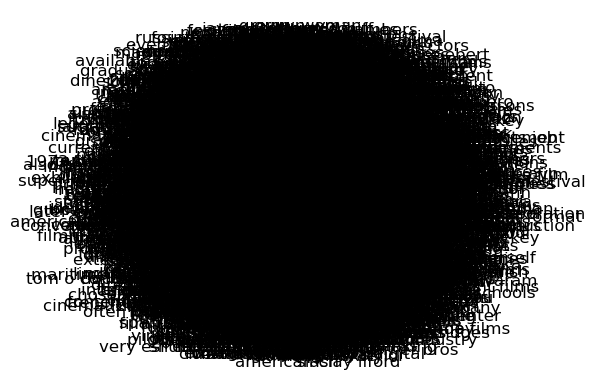

In [12]:
# create a directed-graph from a dataframe (network)
# G = nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())
# plt.figure(figsize=(12,12))
# pos = nx.spring_layout(G)
# nx.draw(G, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos)
# plt.show()

# igraph
G = ig.Graph.DataFrame(kg_df, directed=True, use_vids=False)
fig, ax = plt.subplots()
ig.plot(G, target=ax, vertex_color="red", vertex_label=G.vs["name"])
plt.show()

# Draw Specific Graph

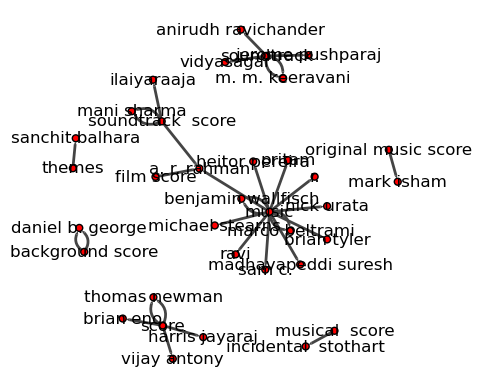

In [13]:
# # networkx
# G = nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())
# plt.figure(figsize=(12,12))
# pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
# nx.draw_networkx(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos, font_weight='bold')
# plt.show()

# igraph
G = ig.Graph.DataFrame(kg_df[kg_df['edge']=="composed by"], directed=True, use_vids=False)
fig, ax = plt.subplots()
ig.plot(G, target=ax, vertex_color="red", vertex_label=G.vs["name"])
plt.show()

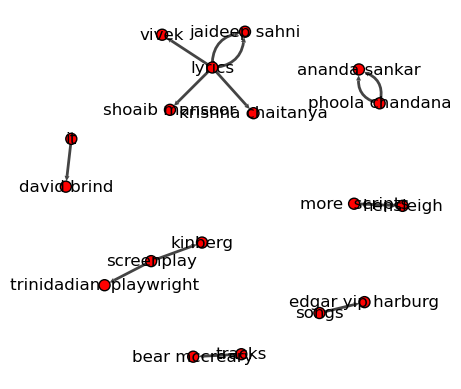

In [14]:
# # networkx
# G = nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())
# plt.figure(figsize=(12,12))
# pos = nx.spring_layout(G, k = 0.5)
# nx.draw_networkx(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
# plt.show()

# igraph
G = ig.Graph.DataFrame(kg_df[kg_df['edge']=="written by"], directed=True, use_vids=False)
fig, ax = plt.subplots()
ig.plot(G, target=ax, vertex_color="red", vertex_label=G.vs["name"])
plt.show()

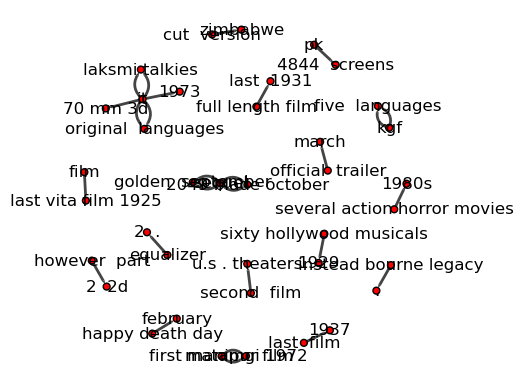

In [15]:
# # networkx
# G = nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())
# plt.figure(figsize=(12,12))
# pos = nx.spring_layout(G, k = 0.5)
# nx.draw_networkx(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
# plt.show()

# igraph
G = ig.Graph.DataFrame(kg_df[kg_df['edge']=="released in"], directed=True, use_vids=False)
fig, ax = plt.subplots()
ig.plot(G, target=ax, vertex_color="red", vertex_label=G.vs["name"])
plt.show()